<a href="https://colab.research.google.com/github/freida20git/child-age-classification/blob/main/weighted_splits_inference_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Pytorch & other libraries
%pip install "torch==2.5.0" "torchvision==0.20.0"
%pip install "setuptools<71.0.0" scikit-learn

# Install Hugging Face libraries
%pip install  --upgrade \
  "datasets==3.1.0" \
  "accelerate==1.2.1" \
  "hf-transfer==0.1.8"

# ModernBERT is not yet available in an official release, so we need to install it from github
%pip install "git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1" --upgrade


In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, AutoConfig
import numpy as np
import torch

In [4]:
from sklearn.metrics import accuracy_score, f1_score


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: [batch_size, num_classes], raw logits
        # targets: [batch_size], integer class labels
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

from transformers import Trainer

class FocalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs["logits"]
        loss_fct = FocalLoss(alpha=1, gamma=2)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [6]:

def tokenize_function(examples):
    return tokenizer(
        examples["child_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Split1:

In [8]:
model_name = "prajjwal1/bert-tiny"
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load model for classification with 3 labels
num_labels = 3

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=0.2,   # default is 0.1, increase to 0.2–0.5 for regularization
    attention_probs_dropout_prob=0.2
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
import os
from datasets import load_dataset
data_path = "/content/drive/MyDrive/age classification/"

dataset = load_dataset('csv',
                       data_files={
                           'train': os.path.join(data_path, 'llmData_train_split1.csv'),
                           'validation': os.path.join(data_path, 'llmData_validation_split1.csv'),
                           'test': os.path.join(data_path, 'llmData_test_split1.csv')
                       })

# Map tokenization over dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

label_map = {"2_3": 0, "3_4": 1, "4_6": 2}

def encode_labels(example):
    example["labels"] = label_map[example["class_range"]]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)

tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/1096 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/1096 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

In [10]:
from collections import Counter
import torch

# Convert labels from tensors to ints
train_labels = [int(x) for x in tokenized_datasets['train']["labels"]]

# Count properly
class_counts = Counter(train_labels)

num_classes = len(class_counts)
total_samples = sum(class_counts.values())

# Compute weights safely
class_weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]

# Convert to tensor and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class counts:", class_counts)
print("Class weights:", class_weights)


Class counts: Counter({2: 495, 0: 313, 1: 288})
Class weights: tensor([1.1672, 1.2685, 0.7380], device='cuda:0')


In [ ]:
#Recompute class_weights if neeeded(here division is same over all splits so no need)


In [11]:
from transformers import Trainer
import torch.nn as nn

In [12]:

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }


class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropy with weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [13]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=3)


In [14]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


In [ ]:
'''trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)'''

In [15]:
# Freeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Ensure top layer is trainable
for param in model.classifier.parameters():
    param.requires_grad = True

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.110600,1.106482,0.298701,0.299365
2,1.113600,1.104347,0.322078,0.321924
3,1.104200,1.102349,0.350649,0.345675
4,1.105200,1.100616,0.353247,0.348285
5,1.103900,1.098957,0.348052,0.346463
6,1.104100,1.097172,0.358442,0.355469
7,1.100000,1.095538,0.397403,0.371641
8,1.099100,1.093729,0.428571,0.385655
9,1.099700,1.092326,0.454545,0.408916
10,1.097800,1.090947,0.425974,0.414835


TrainOutput(global_step=5520, training_loss=1.0758750017138494, metrics={'train_runtime': 67.0565, 'train_samples_per_second': 1307.554, 'train_steps_per_second': 82.319, 'total_flos': 111431050199040.0, 'train_loss': 1.0758750017138494, 'epoch': 80.0})

In [16]:
#Unfreeze and train:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

In [17]:

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)




In [ ]:
'''trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)'''


In [22]:
for param in model.bert.parameters():
    param.requires_grad = True

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.666300,0.750646,0.680519,0.677265
2,0.649700,0.740021,0.680519,0.671187
3,0.635500,0.750182,0.664935,0.657117
4,0.630500,0.745161,0.670130,0.667038
5,0.609700,0.735318,0.670130,0.669328
6,0.591400,0.733167,0.683117,0.675906
7,0.580600,0.771449,0.667532,0.654803
8,0.573000,0.726055,0.685714,0.688695
9,0.556100,0.727472,0.685714,0.689337
10,0.558600,0.721843,0.683117,0.687541


TrainOutput(global_step=1380, training_loss=0.5334268487018088, metrics={'train_runtime': 39.5519, 'train_samples_per_second': 2216.834, 'train_steps_per_second': 139.563, 'total_flos': 27857762549760.0, 'train_loss': 0.5334268487018088, 'epoch': 20.0})

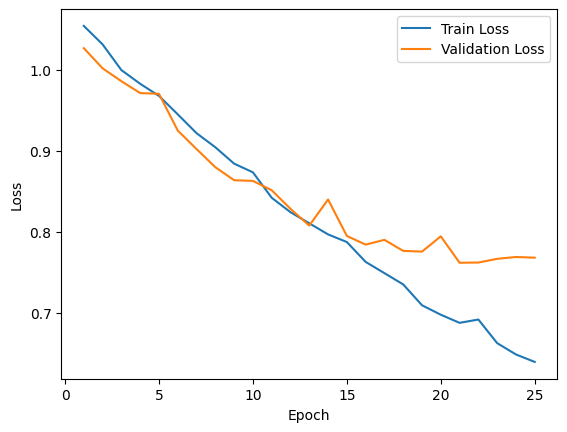

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

# Extract only train and eval losses
train_logs = logs[logs['loss'].notna()]
eval_logs = logs[logs['eval_loss'].notna()]

plt.plot(train_logs['epoch'], train_logs['loss'], label='Train Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
#validation:
predictions = trainer.predict(test_dataset=tokenized_datasets['validation'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.6961038961038961
F1: 0.6980754142518849
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       109
           1       0.46      0.49      0.47       101
           2       0.78      0.74      0.76       175

    accuracy                           0.70       385
   macro avg       0.68      0.68      0.68       385
weighted avg       0.70      0.70      0.70       385



In [24]:
#test:
predictions = trainer.predict(test_dataset=tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.72
F1: 0.7284236332657384
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       102
           1       0.50      0.63      0.56        92
           2       0.84      0.76      0.80       156

    accuracy                           0.72       350
   macro avg       0.72      0.71      0.71       350
weighted avg       0.74      0.72      0.73       350



In [25]:
#trainer.save_model("/content/drive/MyDrive/age_classification/split1_model")
metrics_full = trainer.evaluate(tokenized_datasets['validation'])
print("Full validation metrics:", metrics_full)
metrics_full = trainer.evaluate(tokenized_datasets['test'])
print("Full test metrics:", metrics_full)


Full validation metrics: {'eval_loss': 0.7136520743370056, 'eval_accuracy': 0.6961038961038961, 'eval_f1': 0.6980754142518849, 'eval_runtime': 0.2688, 'eval_samples_per_second': 1432.524, 'eval_steps_per_second': 93.021, 'epoch': 20.0}
Full test metrics: {'eval_loss': 0.6780304908752441, 'eval_accuracy': 0.72, 'eval_f1': 0.7284236332657384, 'eval_runtime': 0.2085, 'eval_samples_per_second': 1678.905, 'eval_steps_per_second': 105.531, 'epoch': 20.0}


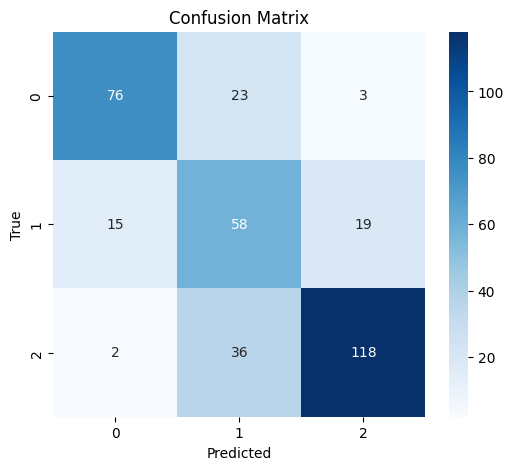

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#split 2

In [28]:
model_name = "prajjwal1/bert-tiny"
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load model for classification with 3 labels
num_labels = 3

from transformers import AutoConfig, AutoModelForSequenceClassification

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=0.2,   # default is 0.1, increase to 0.2–0.5 for regularization
    attention_probs_dropout_prob=0.2
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
data_path = "/content/drive/MyDrive/age classification/"

dataset = load_dataset('csv',
                       data_files={
                           'train': os.path.join(data_path, 'llmData_train_split2.csv'),
                           'validation': os.path.join(data_path, 'llmData_validation_split2.csv'),
                           'test': os.path.join(data_path, 'llmData_test_split2.csv')
                       })

# Map tokenization over dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)
label_map = {"2_3": 0, "3_4": 1, "4_6": 2}

def encode_labels(example):
    example["labels"] = label_map[example["class_range"]]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)

tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/1094 [00:00<?, ? examples/s]

Map:   0%|          | 0/1094 [00:00<?, ? examples/s]

In [30]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropy with weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss



In [31]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [ ]:


trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [32]:
# Freeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Ensure top layer is trainable
for param in model.classifier.parameters():
    param.requires_grad = True
trainer.train()



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.108300,1.100936,0.267062,0.137004
2,1.104400,1.097508,0.278932,0.181520
3,1.101000,1.095667,0.302671,0.244798
4,1.105100,1.092846,0.341246,0.315837
5,1.100900,1.091879,0.364985,0.349976
6,1.098400,1.091252,0.323442,0.279918
7,1.097600,1.088746,0.397626,0.388858
8,1.095900,1.087496,0.415430,0.422750
9,1.097800,1.086361,0.451039,0.463267
10,1.089300,1.083981,0.468843,0.479325


TrainOutput(global_step=5520, training_loss=1.0747998638429503, metrics={'train_runtime': 66.53, 'train_samples_per_second': 1315.497, 'train_steps_per_second': 82.97, 'total_flos': 111227708866560.0, 'train_loss': 1.0747998638429503, 'epoch': 80.0})

In [33]:
#Unfreeze and train:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }


In [34]:

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


In [ ]:


trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [35]:
for param in model.bert.parameters():
    param.requires_grad = True

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.051300,1.029736,0.486647,0.499952
2,1.028900,1.000770,0.516320,0.532099
3,1.010100,0.983461,0.513353,0.524649
4,0.989800,0.966676,0.516320,0.524956
5,0.970800,0.935201,0.554896,0.562282
6,0.935300,0.922171,0.572700,0.566805
7,0.912000,0.901612,0.587537,0.578401
8,0.888500,0.884694,0.608309,0.595871
9,0.874900,0.860912,0.655786,0.643296
10,0.843000,0.856662,0.655786,0.642845


TrainOutput(global_step=3036, training_loss=0.6723702893112645, metrics={'train_runtime': 86.6036, 'train_samples_per_second': 1010.581, 'train_steps_per_second': 63.739, 'total_flos': 61175239876608.0, 'train_loss': 0.6723702893112645, 'epoch': 44.0})

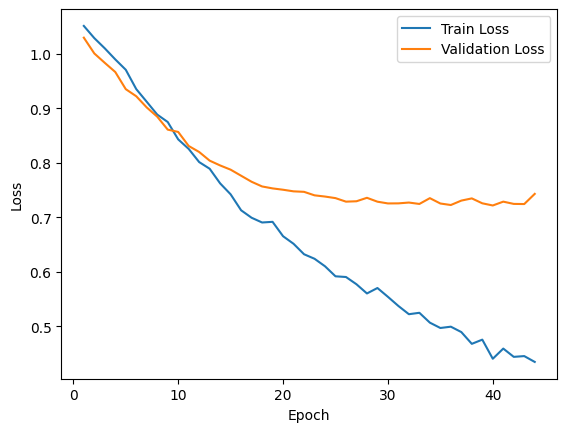

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

# Extract only train and eval losses
train_logs = logs[logs['loss'].notna()]
eval_logs = logs[logs['eval_loss'].notna()]

plt.plot(train_logs['epoch'], train_logs['loss'], label='Train Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [37]:
#validation:
predictions = trainer.predict(test_dataset=tokenized_datasets['validation'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.7151335311572701
F1: 0.7187051677753876
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        83
           1       0.49      0.55      0.52        86
           2       0.83      0.80      0.81       168

    accuracy                           0.72       337
   macro avg       0.69      0.69      0.69       337
weighted avg       0.72      0.72      0.72       337



In [38]:
#test:
predictions = trainer.predict(test_dataset=tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.7075
F1: 0.7003527108228065
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       123
           1       0.51      0.43      0.47       110
           2       0.75      0.81      0.78       167

    accuracy                           0.71       400
   macro avg       0.68      0.69      0.68       400
weighted avg       0.70      0.71      0.70       400



In [39]:
#trainer.save_model("/content/drive/MyDrive/age_classification/split2_model")
metrics_full = trainer.evaluate(tokenized_datasets['validation'])
print("Full validation metrics:", metrics_full)
metrics_full = trainer.evaluate(tokenized_datasets['test'])
print("Full test metrics:", metrics_full)

Full validation metrics: {'eval_loss': 0.7216327786445618, 'eval_accuracy': 0.7151335311572701, 'eval_f1': 0.7187051677753876, 'eval_runtime': 0.2266, 'eval_samples_per_second': 1487.148, 'eval_steps_per_second': 97.084, 'epoch': 44.0}
Full test metrics: {'eval_loss': 0.7117266654968262, 'eval_accuracy': 0.7075, 'eval_f1': 0.7003527108228065, 'eval_runtime': 0.2282, 'eval_samples_per_second': 1752.847, 'eval_steps_per_second': 109.553, 'epoch': 44.0}


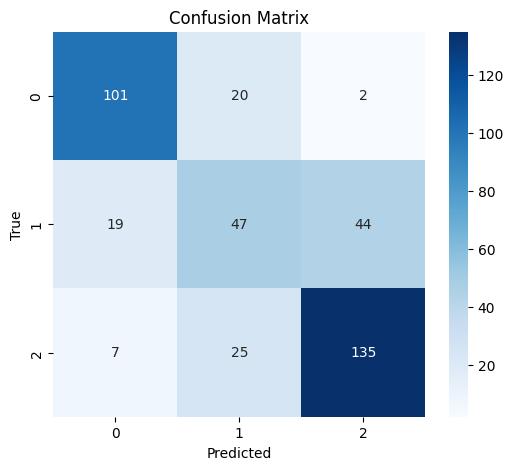

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Split3

In [41]:
model_name = "prajjwal1/bert-tiny"
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load model for classification with 3 labels
num_labels = 3

from transformers import AutoConfig, AutoModelForSequenceClassification

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=0.2,   # default is 0.1, increase to 0.2–0.5 for regularization
    attention_probs_dropout_prob=0.2
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

def tokenize_function(examples):
    return tokenizer(
        examples["child_text"],
        padding="max_length",  # pad to max_length
        truncation=True,       # truncate longer text
        max_length=512          # adjust if needed
    )

import os
from datasets import load_dataset
data_path = "/content/drive/MyDrive/age classification/"

dataset = load_dataset('csv',
                       data_files={
                           'train': os.path.join(data_path, 'llmData_train_split3.csv'),
                           'validation': os.path.join(data_path, 'llmData_validation_split3.csv'),
                           'test': os.path.join(data_path, 'llmData_test_split3.csv')
                       })
# Map tokenization over dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

label_map = {"2_3": 0, "3_4": 1, "4_6": 2}

def encode_labels(example):
    example["labels"] = label_map[example["class_range"]]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)

tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1095 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

Map:   0%|          | 0/1095 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

In [42]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropy with weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [43]:

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)




In [44]:
# Freeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Ensure top layer is trainable
for param in model.classifier.parameters():
    param.requires_grad = True
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.113400,1.127041,0.402089,0.231051
2,1.110600,1.115057,0.404700,0.240968
3,1.104500,1.108508,0.417755,0.296239
4,1.100300,1.105961,0.415144,0.295755
5,1.096500,1.103972,0.420366,0.307597
6,1.098100,1.102561,0.430809,0.315086
7,1.097900,1.099695,0.456919,0.365876
8,1.093800,1.098497,0.462141,0.375213
9,1.091800,1.097275,0.467363,0.381255
10,1.090600,1.095287,0.464752,0.394533


TrainOutput(global_step=5520, training_loss=1.0747147173121356, metrics={'train_runtime': 68.8574, 'train_samples_per_second': 1272.194, 'train_steps_per_second': 80.166, 'total_flos': 111329379532800.0, 'train_loss': 1.0747147173121356, 'epoch': 80.0})

In [45]:
#Unfreeze and train:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }


In [46]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


In [ ]:
trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


In [47]:
for param in model.bert.parameters():
    param.requires_grad = True

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.054200,1.031948,0.488251,0.461700
2,1.028400,1.008802,0.467363,0.433521
3,1.004300,0.991508,0.548303,0.536903
4,0.978700,0.977574,0.516971,0.529683
5,0.945800,0.945175,0.545692,0.551203
6,0.923200,0.923877,0.553525,0.555765
7,0.898600,0.917423,0.556136,0.557444
8,0.877800,0.903446,0.561358,0.561686
9,0.836600,0.890702,0.584856,0.582452
10,0.820400,0.901039,0.590078,0.595702


TrainOutput(global_step=1242, training_loss=0.8491395713818438, metrics={'train_runtime': 35.803, 'train_samples_per_second': 2446.722, 'train_steps_per_second': 154.177, 'total_flos': 25049110394880.0, 'train_loss': 0.8491395713818438, 'epoch': 18.0})

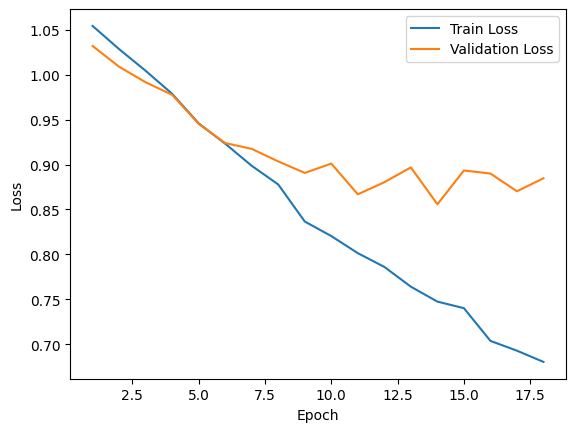

In [48]:
logs = pd.DataFrame(trainer.state.log_history)

# Extract only train and eval losses
train_logs = logs[logs['loss'].notna()]
eval_logs = logs[logs['eval_loss'].notna()]

plt.plot(train_logs['epoch'], train_logs['loss'], label='Train Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [49]:
#trainer.save_model("/content/drive/MyDrive/age_classification/split3_model")

metrics_full = trainer.evaluate(tokenized_datasets['test'])
print("Full model metrics:", metrics_full)


Full model metrics: {'eval_loss': 0.7851871848106384, 'eval_accuracy': 0.660056657223796, 'eval_f1': 0.6490447646809268, 'eval_runtime': 0.2586, 'eval_samples_per_second': 1365.268, 'eval_steps_per_second': 88.955, 'epoch': 18.0}


In [50]:
#valid:
predictions = trainer.predict(test_dataset=tokenized_datasets['validation'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.6292428198433421
F1: 0.6297358816941063
              precision    recall  f1-score   support

           0       0.81      0.61      0.69       127
           1       0.41      0.42      0.41       102
           2       0.66      0.79      0.72       154

    accuracy                           0.63       383
   macro avg       0.63      0.60      0.61       383
weighted avg       0.64      0.63      0.63       383



In [51]:
#test:
predictions = trainer.predict(test_dataset=tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.660056657223796
F1: 0.6490447646809268
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        81
           1       0.46      0.36      0.40       103
           2       0.71      0.80      0.76       169

    accuracy                           0.66       353
   macro avg       0.64      0.63      0.63       353
weighted avg       0.64      0.66      0.65       353



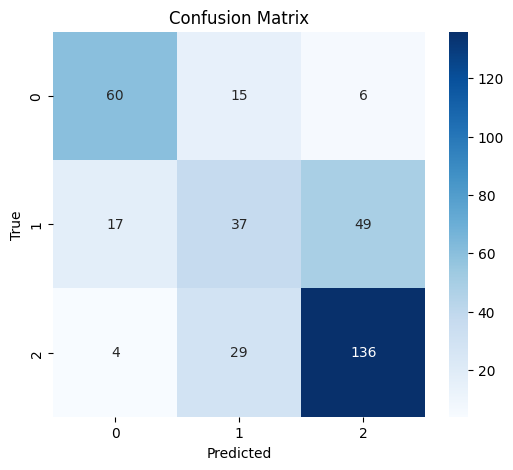

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#

AVEREGE:
| Metric   | Split 1 | Split 2 | Split 3 | **Mean**   |
| -------- | ------- | ------- | ------- | ---------- |
| Accuracy | 0.72    | 0.71    | 0.66    | 0.69       |
| F1 score | 0.73    | 0.70    | 0.65    | 0.69       |
